<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/4-training-models/03_regularization_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Regularization Fundamentals

A good way to reduce overfitting is to regularize the
model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce
the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of
the model. We will now look at Ridge Regression, Lasso Regression, and Elastic Net,
which implement three different ways to constrain the weights.

##Setup

In [6]:
# Common imports
import numpy as np
import numpy.random as rnd
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

##Ridge Regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear
Regression: a regularization term equal to $\alpha\sum_{i=1}^n \theta_i^2$ is added to the cost function.
This forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. Note that the regularization term should only be added
to the cost function during training. Once the model is trained, you want to use the
unregularized performance measure to evaluate the model’s performance.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$,
then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end
up very close to zero and the result is a flat line going through the data’s mean.

$$
J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^n \theta_i^2
$$

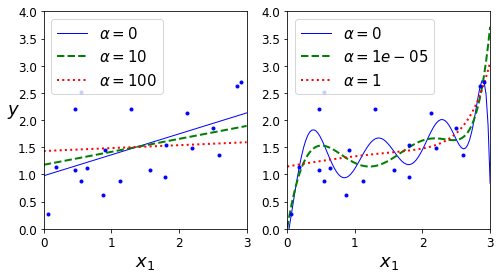

In [3]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

Note how
increasing $\alpha$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus
reducing the model’s variance but increasing its bias.

As with Linear Regression, we can perform Ridge Regression either by computing a
closed-form equation or by performing Gradient Descent. The pros and cons are the same.

$$
\hat\theta = (X^TX + \alpha A)^{-1} X^T y
$$

Here is how to perform Ridge Regression with Scikit-Learn using a closed-form solution.

In [4]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

And using Stochastic Gradient Descent:

In [5]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.46543286])

Specifying
"l2" indicates that you want SGD to add a regularization term to the cost function
equal to half the square of the ℓ2 norm of the weight vector: this is simply Ridge
Regression.

##Lasso Regression

Least Absolute Shrinkage and Selection Operator Regression (usually simply called
Lasso Regression) is another regularized version of Linear Regression: just like Ridge
Regression, it adds a regularization term to the cost function, but it uses the $L_1$ norm
of the weight vector instead of half the square of the $L_2$ norm.


$$
J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^n |\theta_i|
$$

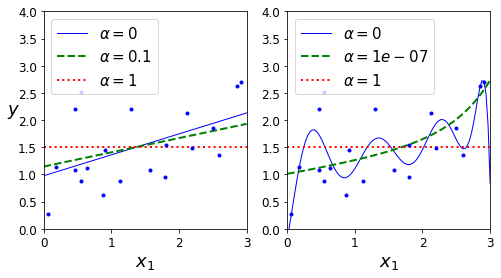

In [7]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

An important characteristic of Lasso Regression is that it tends to eliminate the
weights of the least important features (i.e., set them to zero).

The Lasso cost function is not differentiable at $\theta_i = 0$ (for `i = 1, 2, ⋯, n`), but Gradient
Descent still works fine if you use a subgradient vector $g$ instead when any $\theta_i = 0$.

$
g(\boldsymbol{\theta}, J) = \nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta}) + \alpha
\begin{pmatrix}
  \operatorname{sign}(\theta_1) \\
  \operatorname{sign}(\theta_2) \\
  \vdots \\
  \operatorname{sign}(\theta_n) \\
\end{pmatrix} \quad \text{where } \operatorname{sign}(\theta_i) =
\begin{cases}
-1 & \text{if } \theta_i < 0 \\
0 & \text{if } \theta_i = 0 \\
+1 & \text{if } \theta_i > 0
\end{cases}
$

Here is a small Scikit-Learn example using the Lasso class:

In [8]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Note that you could instead use `SGDRegressor(penalty="l1")`.

In [12]:
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.44587236])

##Elastic Net